# Импортируем phout и считаем по нему разное

In [1]:
# подключаем библиотеки
%matplotlib inline
import json
import os
import glob
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

base_path = "/vagrant/tests/loadtests"

def path_logs(folder):
    all_subdirs = [os.path.join(base_path, folder, d) for d in os.listdir(os.path.join(base_path, folder)) if os.path.isdir(os.path.join(base_path, folder, d))]
    latest_subdir = max(all_subdirs, key=os.path.getmtime)
    return glob.glob(latest_subdir + '/phout_*.log')[0], latest_subdir + '/monitoring.log'

In [26]:
def request_graph(path_to_log):
    # импортируем пхаут
    phout_columns = [
        'time', 'tag', 'interval_real',
        'connect_time', 'send_time',
        'latency', 'receive_time',
        'interval_event', 'size_out',
        'size_in', 'net_code', 'proto_code']
    data = pd.read_csv(
        path_to_log,
        sep='\t', names=phout_columns)
    # хитрые манипуляции с колонками:
    # высчитываем время получения - будем группировать по нему (заводим новую колонку)
    data['ts'] = data.time + data.interval_real / 1000000
    # округляем до секунды
    data['receive_sec'] = data.ts.astype(int)
    # и индексируем по этой секунде
    data.set_index(['receive_sec'], inplace=True)
    # для удобства посчитаем респонс тайм в миллисекундах
    data['rt_ms'] = data.interval_real / 1000
    # группируем по индексу, считаем и рисуем график
    data[:10]
    data.groupby(level=0).count().time.plot(title="RPS")
    plt.show()
    # группируем по индексу, считаем разные агрегаты и рисуем график
    data.groupby(level=0).rt_ms.agg([np.mean, np.std, np.median]).plot(title='delay')
    plt.show()
    data = data.proto_code.groupby(level=0).value_counts()
    data = data.unstack(level=1).fillna(0)
    data.plot(title='http codes')
    plt.show()

def system_graph(path_to_log):
    columns = ['timestamp', 'memory_used', 'num_fd', 'cpu']
    data = []
    with open(path_to_log) as f:
        for line in f:
            if line == "[]\n":
                continue
            raw = json.loads(line)[0]
            timestamp = raw['timestamp']
            memory_used = float(raw['data'].values()[0]['metrics']['Memory_used']) / 10**6
            num_fd = raw['data'].values()[0]['metrics']['custom:None']
            cpu = 100 - raw['data'].values()[0]['metrics'].get('custom:cpu-cpu-total_usage_idle', 100.)
            data.append([timestamp, memory_used, num_fd, cpu])
    data = pd.DataFrame(data=data, columns=columns)
    data.set_index(['timestamp'], inplace=True)
    for i in columns[1:]:
        data[i].plot(title=i)
        plt.show()

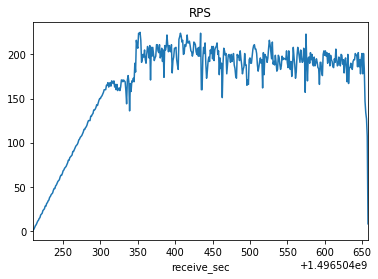

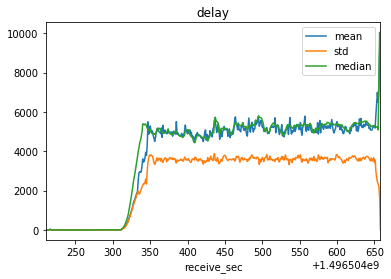

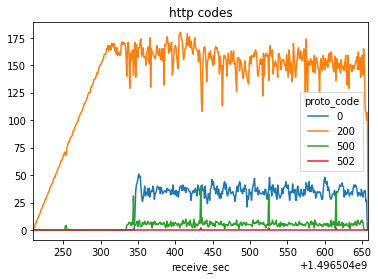

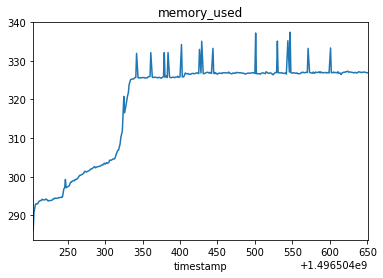

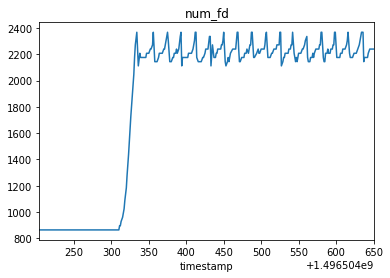

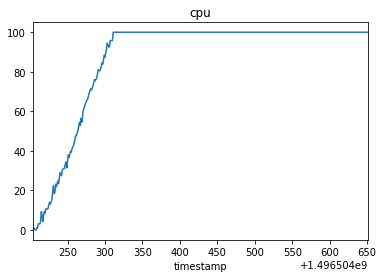

In [27]:
# authorisation sha256
a, b = path_logs('authsha256')
request_graph(a)
system_graph(b)

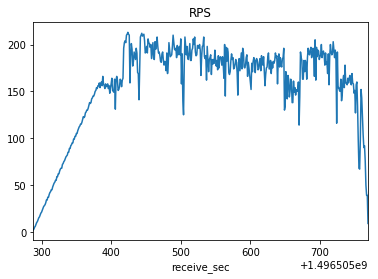

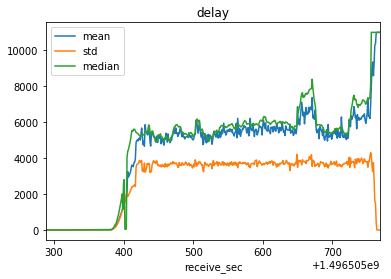

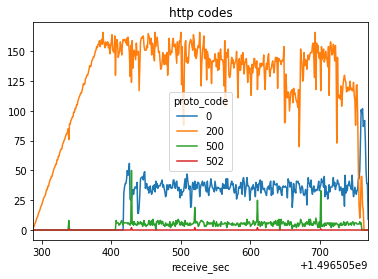

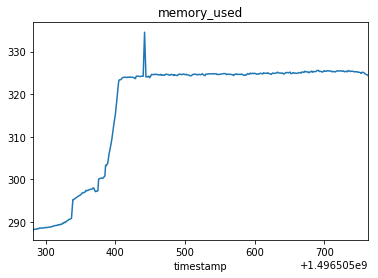

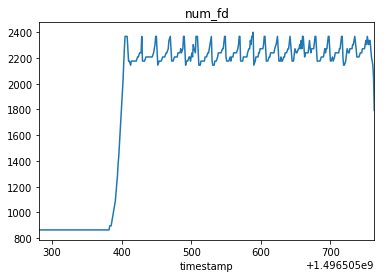

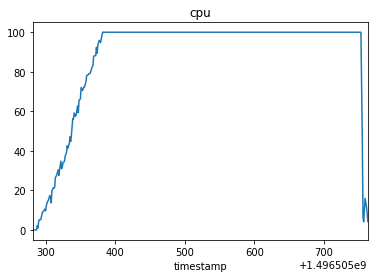

In [4]:
# authorisation pbkdf2
a, b = path_logs('authpbkdf2')
request_graph(a)
system_graph(b)

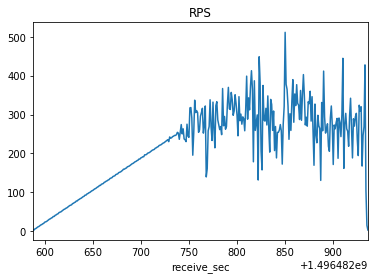

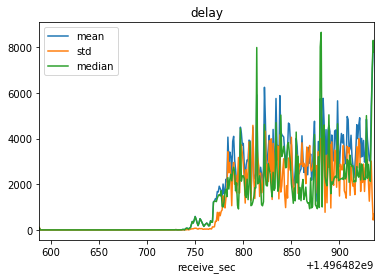

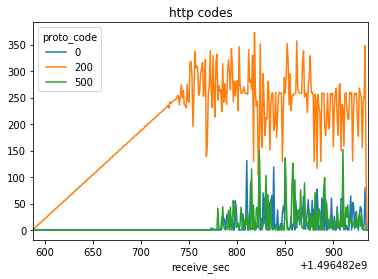

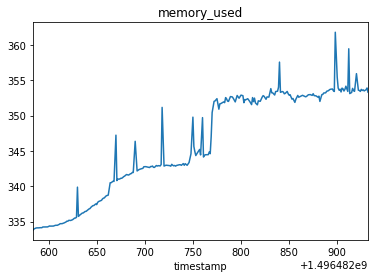

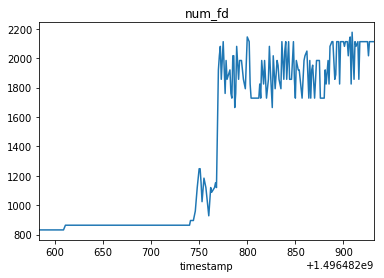

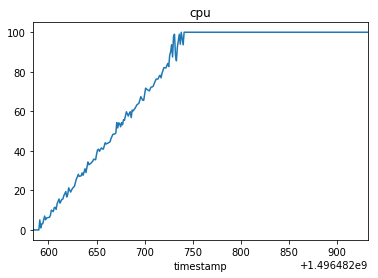

In [5]:
# calc
a,b = path_logs('calc')
request_graph(a)
system_graph(b)

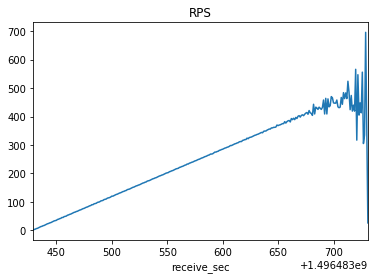

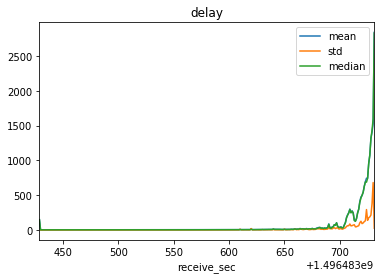

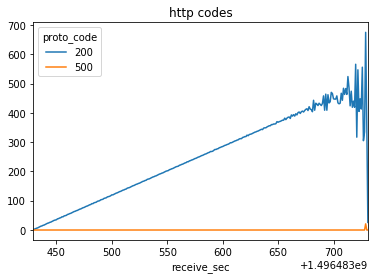

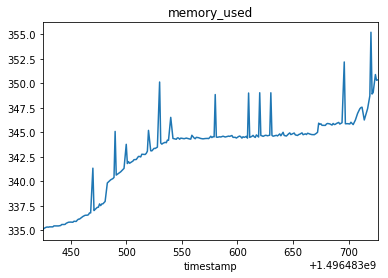

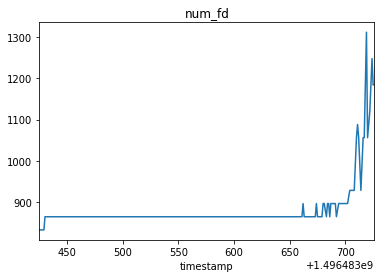

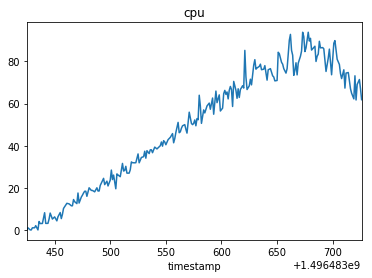

In [6]:
# fast
a,b = path_logs('fast')
request_graph(a)
system_graph(b)

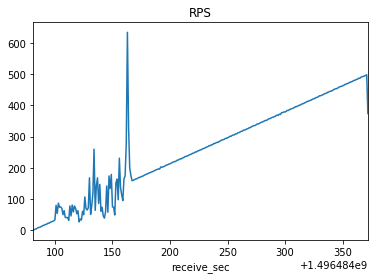

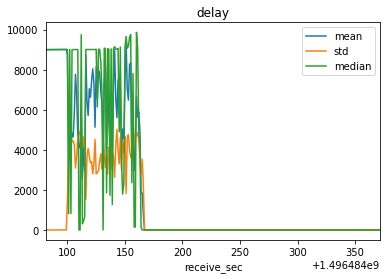

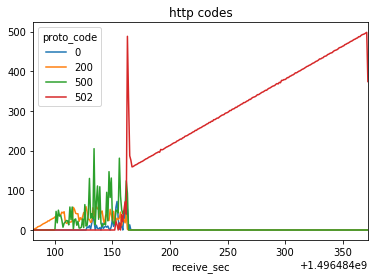

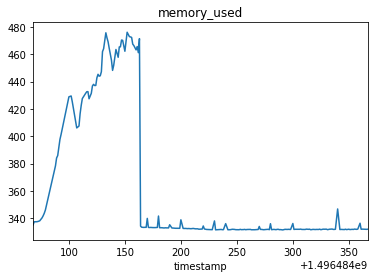

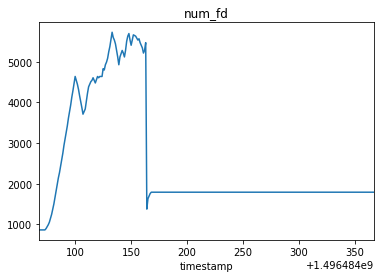

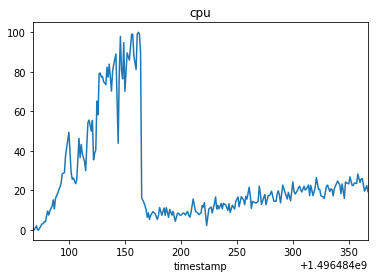

In [7]:
# ping
a,b = path_logs('ping')
request_graph(a)
system_graph(b)

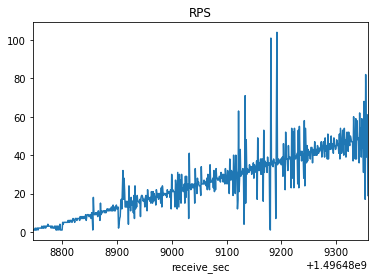

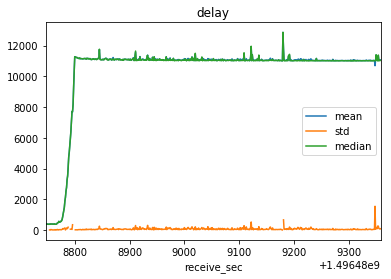

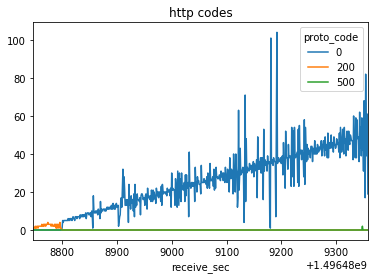

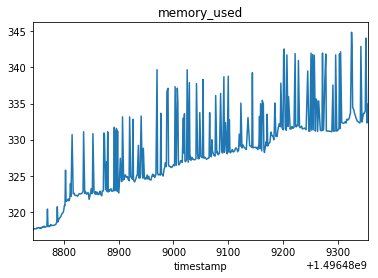

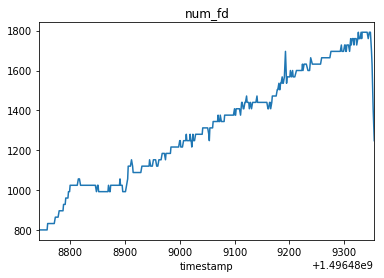

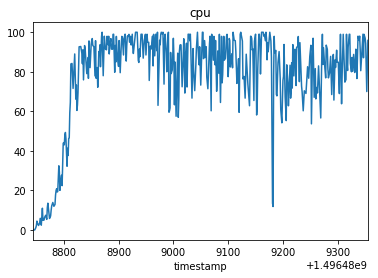

In [8]:
# nginx
a,b = path_logs('bigfiles80')
request_graph(a)
system_graph(b)

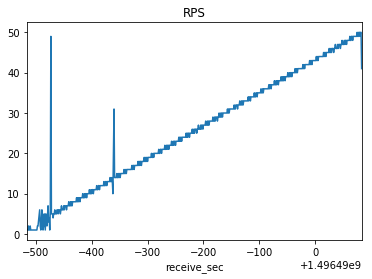

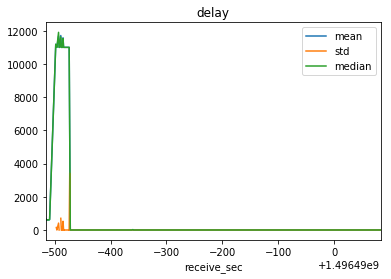

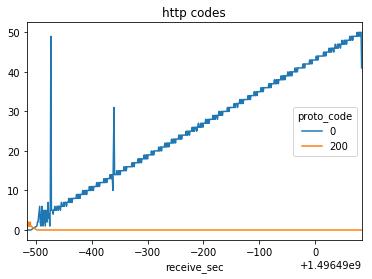

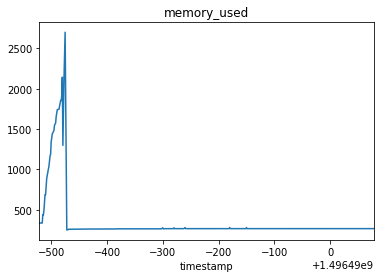

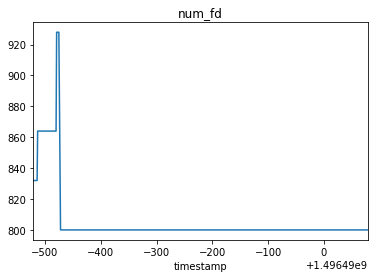

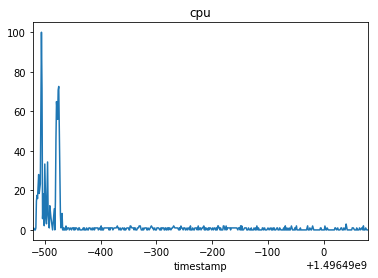

In [9]:
# server
a,b = path_logs('bigfiles8080')
request_graph(a)
system_graph(b)

## Пользователи часто регистрируются и логинятся/выходят из приложения (нагрузка на систему аутентификации и работы с паролями).
* sha256
* pbkdf2
Существенной разницы между двумя этими двумя шифрами незамечено. Однако, pbkdf2 вернул меньше ответов с кодом 200 клиенту. При этом ему удалось более плавно нагрузить систему, без резких всплесков потребления памяти и cpu. Кажется, что sha256 более простой, но при этом мне пришлось писать собственный цикл для работы с паролями, в то время как pbkdf2 этого не требует. Т.е цикл там написан на языке С за меня. 

## Много пользователей одновременно приходят на одну из функций приложения (отдельно на "быструю", "вычислительную" и "медленную").
### быструю
В силу ограничений драйвера для  redis мне не удалось возможность выполнять запросы к бд, которые прислал клиент через POST запрос. Однако, ограничения yandex-tank c phantom таковы, что мне не удалось сделать тест вариативным. В итоге из-за этих двух сложностей, у меня построянно выполнялся один и тот же запрос к редис. Так как redis не писал на диск и был запущен локально, то отвечал максимально быстро. В результате, узким местом стал сам сервер, написанный на python. График, котрый получился прекрасно показывает, на что способно 1 ядро и что тест не до конца нагрузил сервер. Я не стал менять этот тест, для наглядности, так как такиеже нагрузки были для 1 части задания.

### вычислительную
По графикам отлично видно, что нагрузка была на cpu и как только cpu оказался полностью загружен, то ОС призодилось решать, для какой из задач отводить процессорное время. До того как процессор был нагружен полностью наблюдался линейный рост нагрузки.

### медленную
Получается, что медленная часть нагрузила систему. которая отвечает за работу с сетью. По графику файловых дескрипторов видно, что их было запрошено до 5000 при таком малок количестве запросов. Сервер долго отвечал. Потом стал просто отвечать 502 ошибкой. Объективных причин так делать выявлено не было. Никакой процесс не падал. Полагаю, что из-за долгого времени ответа, тест просто закончился и не создавал боьше новых запросов. Так же нагрузка на процессор была высока, полагаю, что это из-за того,ч то призодилось слишком часто переключать контекс ведь было запущено одновременно много пингов

## Много пользователей запрашивают статические ресурсы.
По последним графикам прекрасно видно. почему статику надо отдавать с помощью nginx, а не с помощью самописного сервиса. Nginx смог всем клиентам отдать 4 файла с кодом 200. В то время как мой web сервер не смог обработать такое количество долгих запросов и требовал очень много памяти. Потому что я читал файл с диска при каждом запросе в память, а потом отдавал его.

## Итог
Считаю, что серверное приложение, который я написал недостаточно оптимизирован. Например можно было читать из файла кусками и отдавать их клиенту. Вычислительные задачи, сильно тормозили сервер и не позволяли выдержать возврастающую нагрузку. Сложные задачи стоит отдать на откуп брокерам очередей, которые смогут более равномерно распределить нагрузку, а в случае роста нагрузки поволят легке отмасштабировать узкие части моего сервиса.
Тест так же подтвердил бест практис, что статику должен отдавать nginx, если он есть.